<a href="https://colab.research.google.com/github/KIMHYOENJUN/AI_project/blob/main/LSTM%EC%9D%84_%ED%99%9C%EC%9A%A9%ED%95%9C_%EC%82%BC%EC%84%B1%EC%A0%84%EC%9E%90_%EC%A3%BC%EA%B0%80%EC%98%88%EC%B8%A1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LSTM을 활용한 주가 예측 모델

이번 튜토리얼 에서는 다음과 같은 **프로세스 파이프라인**으로 주가 예측을 진행합니다.

- FinanceDataReader를 활용하여 주가 데이터 받아오기
- TensorFlow Dataset 클래스를 활용하여 주가 데이터 구축
- LSTM 을 활용한 주가 예측 모델 구축

## 필요한 모듈 import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os

%matplotlib inline
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (15, 20)

plt.rcParams['font.family'] = 'NanumGothic'

## 데이터 (FinanceDataReader)

**FinanceDataReader**는 주가 데이터를 편리하게 가져올 수 있는 파이썬 패키지입니다.

- [GitHub Repo](https://github.com/FinanceData/FinanceDataReader)

**FinanceDataReader**설치

In [2]:
!pip install finance-datareader

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import FinanceDataReader as fdr

In [4]:
# 삼성전자(005930) 전체 (1996-11-05 ~ 현재)
samsung = fdr.DataReader('005930')

매우 편리하게 삼성전자 주가 데이터를 `DataFrame`형식으로 받아옵니다.

기본 **오름차순 정렬**이 된 데이터임을 알 수 있습니다.

### 컬럼 설명

- `Open`:   시가
- `High`:   고가
- `Low`:    저가
- `Close`:  종가
- `Volume`: 거래량
- `Change`: 대비

In [5]:
samsung.tail()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2022-07-04,56100,57400,55700,57100,17807126,0.016014
2022-07-05,57600,58200,57200,57200,14216539,0.001751
2022-07-06,57300,57300,56400,56400,16820461,-0.013986
2022-07-07,56400,58700,56300,58200,21322833,0.031915
2022-07-08,58600,59300,58200,58700,15179249,0.008591


**미국 주식 데이터**도 가져올 수 있습니다.

In [6]:
# Apple(AAPL), 애플
apple = fdr.DataReader('AAPL')

In [7]:
apple.tail()

,Close,Open,High,Low,Volume,Change
Date,,,,,,
2022-07-01,138.93,136.04,139.04,135.66,71050000.0,0.0162
2022-07-05,141.56,137.77,141.61,136.93,70950000.0,0.0189
2022-07-06,142.92,141.35,144.12,141.08,73550000.0,0.0096
2022-07-07,146.35,143.29,146.55,143.28,65730000.0,0.0240
2022-07-08,147.04,145.26,147.55,145.00,64300000.0,0.0047


다음과 같이 `2017`을 같이 넘겨주면, 해당 시점 이후의 주식 데이터를 가져옵니다.

In [8]:
# Apple(AAPL), 애플
apple = fdr.DataReader('AAPL', '2017')

In [9]:
apple.head()

,Close,Open,High,Low,Volume,Change
Date,,,,,,
2017-01-03,29.04,28.95,29.08,28.69,115130000.0,0.0031
2017-01-04,29.00,28.96,29.13,28.94,84470000.0,-0.0014
2017-01-05,29.15,28.98,29.22,28.95,88770000.0,0.0052
2017-01-06,29.48,29.20,29.54,29.12,127010000.0,0.0113
2017-01-09,29.75,29.49,29.86,29.48,134250000.0,0.0092


**시작**과 **끝** 날짜를 지정하여 범위 데이터를 가져올 수 있습니다.

In [10]:
# Ford(F), 1980-01-01 ~ 2019-12-30 (40년 데이터)
ford = fdr.DataReader('F', '1980-01-01', '2019-12-30')

In [11]:
ford.head()

,Close,Open,High,Low,Volume,Change
Date,,,,,,
1980-03-18,1.83,1.83,1.85,1.82,3770000.0,-0.0108
1980-03-19,1.85,1.85,1.86,1.83,1560000.0,0.0109
1980-03-20,1.86,1.86,1.88,1.85,1450000.0,0.0054
1980-03-21,1.78,1.78,1.85,1.76,5020000.0,-0.0430
1980-03-24,1.71,1.71,1.75,1.66,3330000.0,-0.0393


In [12]:
ford.tail()

,Close,Open,High,Low,Volume,Change
Date,,,,,,
2019-12-23,9.44,9.50,9.57,9.40,54800000.0,-0.0042
2019-12-24,9.47,9.44,9.49,9.43,11880000.0,0.0032
2019-12-26,9.45,9.47,9.49,9.43,28980000.0,-0.0021
2019-12-27,9.36,9.45,9.46,9.35,28270000.0,-0.0095
2019-12-30,9.25,9.34,9.35,9.23,36090000.0,-0.0118


그 밖에 **금, 은과 같은 현물**, **달러와 같은 화폐** 데이터도 가져올 수 있습니다.

In [ ]:
## 주가데이터 가져오기

**삼성전자**의 주가데이터를 가져와서 예측

In [13]:
# 네이버 주식코드: 035420 
STOCK_CODE = '035420'

In [14]:
stock = fdr.DataReader(STOCK_CODE)

In [15]:
stock.head()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2002-10-29,2312,2312,2312,2312,20549,NaN
2002-10-30,2587,2587,2558,2588,853638,0.119377
2002-10-31,2626,2689,2398,2459,1320880,-0.049845
2002-11-01,2520,2599,2215,2305,750761,-0.062627
2002-11-04,2285,2300,2135,2191,692165,-0.049458


In [16]:
stock.tail()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2022-07-04,237500,240000,230500,235000,512776,-0.008439
2022-07-05,238500,248500,237000,243000,654854,0.034043
2022-07-06,240000,249500,236500,243500,875386,0.002058
2022-07-07,246000,249000,243000,245000,547620,0.006160
2022-07-08,247000,252500,246000,249000,651000,0.016327


In [17]:
stock.index

DatetimeIndex(['2002-10-29', '2002-10-30', '2002-10-31', '2002-11-01',
               '2002-11-04', '2002-11-05', '2002-11-06', '2002-11-07',
               '2002-11-08', '2002-11-11',
               ...
               '2022-06-27', '2022-06-28', '2022-06-29', '2022-06-30',
               '2022-07-01', '2022-07-04', '2022-07-05', '2022-07-06',
               '2022-07-07', '2022-07-08'],
              dtype='datetime64[ns]', name='Date', length=4871, freq=None)

위에서 보시는 바와 같이 index가 `DatetimeIndex`로 지정되어 있습니다.

`DatetimeIndex`로 정의되어 있다면, 아래와 같이 연도, 월, 일을 쪼갤 수 있으며, **월별, 연도별 피벗데이터**를 만들때 유용하게 활용할 수 있습니다.

In [18]:
stock['Year'] = stock.index.year
stock['Month'] = stock.index.month
stock['Day'] = stock.index.day

In [19]:
stock.head()

,Open,High,Low,Close,Volume,Change,Year,Month,Day
Date,,,,,,,,,
2002-10-29,2312,2312,2312,2312,20549,NaN,2002,10,29
2002-10-30,2587,2587,2558,2588,853638,0.119377,2002,10,30
2002-10-31,2626,2689,2398,2459,1320880,-0.049845,2002,10,31
2002-11-01,2520,2599,2215,2305,750761,-0.062627,2002,11,1
2002-11-04,2285,2300,2135,2191,692165,-0.049458,2002,11,4


## 시각화

Text(0, 0.5, 'price')

findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.


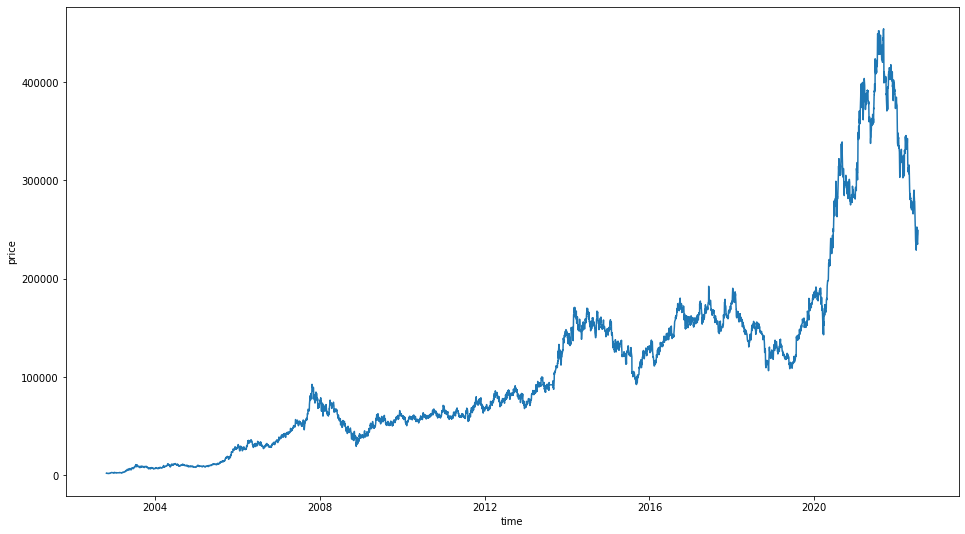

In [20]:
plt.figure(figsize=(16, 9))
sns.lineplot(y=stock['Close'], x=stock.index)
plt.xlabel('time')
plt.ylabel('price')

findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.


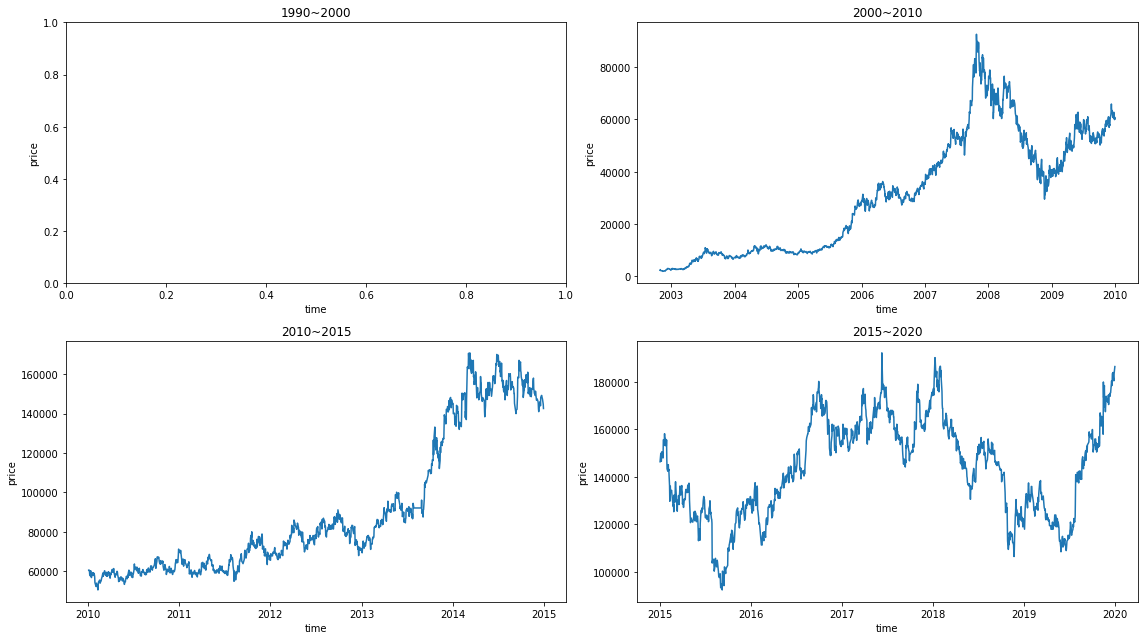

In [21]:
time_steps = [['1990', '2000'], # 특정기간을 설정하여 subplot 표현
              ['2000', '2010'], 
              ['2010', '2015'], 
              ['2015', '2020']]

fig, axes = plt.subplots(2, 2)
fig.set_size_inches(16, 9)
for i in range(4):
    ax = axes[i//2, i%2]
    df = stock.loc[(stock.index > time_steps[i][0]) & (stock.index < time_steps[i][1])]
    sns.lineplot(y=df['Close'], x=df.index, ax=ax) # 선형플롯
    ax.set_title(f'{time_steps[i][0]}~{time_steps[i][1]}')
    ax.set_xlabel('time')
    ax.set_ylabel('price')
plt.tight_layout()
plt.show()

## 데이터 전처리

주가 데이터에 대하여 딥러닝 모델이 더 잘 학습할 수 있도록 **정규화(Normalization)**를 해주도록 하겠습니다.

**표준화 (Standardization)**와 **정규화(Normalization)**에 대한 내용은 아래 링크에서 더 자세히 다루니, 참고해 보시기 바랍니다.

- [데이터 전처리에 관하여](https://teddylee777.github.io/scikit-learn/scikit-learn-preprocessing)

In [22]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler() # MinMaxScaler 인스턴스화

# 스케일을 적용할 column을 정의합니다.
scale_cols = ['Open', 'High', 'Low', 'Close', 'Volume']

# 스케일 후 columns
scaled = scaler.fit_transform(stock[scale_cols])
scaled

array([[0.00502609, 0.00497204, 0.00511504, 0.00086047, 0.00387387],
       [0.00562391, 0.00556344, 0.00565929, 0.00147099, 0.16092656],
       [0.0057087 , 0.0057828 , 0.00530531, 0.00118564, 0.24901032],
       ...,
       [0.52173913, 0.53655914, 0.52323009, 0.53437136, 0.16502646],
       [0.53478261, 0.53548387, 0.53761062, 0.53768938, 0.1032365 ],
       [0.53695652, 0.54301075, 0.54424779, 0.54653743, 0.12272555]])

스케일이 완료된 column으로 새로운 데이터프레임을 생성합니다.

**시간 순으로 정렬**되어 있으며, datetime index는 제외

*6,000개의 row, 5개 column*으로 이루어진 데이터셋이 DataFrame으로 정리되었습니다.

In [23]:
df = pd.DataFrame(scaled, columns=scale_cols)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4871 entries, 0 to 4870
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    4871 non-null   float64
 1   High    4871 non-null   float64
 2   Low     4871 non-null   float64
 3   Close   4871 non-null   float64
 4   Volume  4871 non-null   float64
dtypes: float64(5)
memory usage: 190.4 KB


## train / test 분할

In [24]:
from sklearn.model_selection import train_test_split

In [25]:
x_train, x_test, y_train, y_test = train_test_split(df.drop('Close', 1), df['Close'], test_size=0.2, random_state=0, shuffle=False)

In [26]:
x_train.shape, y_train.shape

((3896, 4), (3896,))

In [27]:
x_test.shape, y_test.shape

((975, 4), (975,))

In [28]:
x_train

,Open,High,Low,Volume
0,0.005026,0.004972,0.005115,0.003874
1,0.005624,0.005563,0.005659,0.160927
2,0.005709,0.005783,0.005305,0.249010
3,0.005478,0.005589,0.004900,0.141532
4,0.004967,0.004946,0.004723,0.130486
...,...,...,...,...
3891,0.331774,0.332084,0.336316,0.005988
3892,0.336128,0.335959,0.338088,0.009505
3893,0.333078,0.332510,0.334542,0.009511
3894,0.335691,0.334665,0.338973,0.015351


## TensroFlow Dataset을 활용한 시퀀스 데이터셋 구성

In [29]:
import tensorflow as tf

In [30]:
def windowed_dataset(series, window_size, batch_size, shuffle):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    if shuffle:
        ds = ds.shuffle(1000)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    return ds.batch(batch_size).prefetch(1)

Hyperparameter를 정의합니다.

In [31]:
WINDOW_SIZE=20
BATCH_SIZE=32

In [32]:
# train_data는 학습용 데이터셋, test_data는 검증용 데이터셋 입니다.
train_data = windowed_dataset(y_train, WINDOW_SIZE, BATCH_SIZE, True)
test_data = windowed_dataset(y_test, WINDOW_SIZE, BATCH_SIZE, False)

In [33]:
# 아래의 코드로 데이터셋의 구성을 확인해 볼 수 있습니다.
# X: (batch_size, window_size, feature)
# Y: (batch_size, feature)
for data in train_data.take(1):
    print(f'데이터셋(X) 구성(batch_size, window_size, feature갯수): {data[0].shape}')
    print(f'데이터셋(Y) 구성(batch_size, window_size, feature갯수): {data[1].shape}')

데이터셋(X) 구성(batch_size, window_size, feature갯수): (32, 20, 1)
데이터셋(Y) 구성(batch_size, window_size, feature갯수): (32, 1)


## 모델

In [34]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Lambda
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


model = Sequential([
    # 1차원 feature map 생성
    Conv1D(filters=32, kernel_size=5,
           padding="causal",
           activation="relu",
           input_shape=[WINDOW_SIZE, 1]),
    # LSTM
    LSTM(16, activation='tanh'),
    Dense(16, activation="relu"),
    Dense(1),
])

In [35]:
# Sequence 학습에 비교적 좋은 퍼포먼스를 내는 Huber()를 사용합니다.
loss = Huber()
optimizer = Adam(0.0005)
model.compile(loss=Huber(), optimizer=optimizer, metrics=['mse'])

In [36]:
# earlystopping은 10번 epoch통안 val_loss 개선이 없다면 학습을 멈춥니다.
earlystopping = EarlyStopping(monitor='val_loss', patience=10)
# val_loss 기준 체크포인터도 생성합니다.
filename = os.path.join('tmp', 'ckeckpointer.ckpt')
checkpoint = ModelCheckpoint(filename, 
                             save_weights_only=True, 
                             save_best_only=True, 
                             monitor='val_loss', 
                             verbose=1)

In [37]:
history = model.fit(train_data, 
                    validation_data=(test_data), 
                    epochs=50, 
                    callbacks=[checkpoint, earlystopping])

Epoch 1/50
    122/Unknown - 15s 7ms/step - loss: 2.3540e-04 - mse: 4.7081e-04
Epoch 1: val_loss improved from inf to 0.00146, saving model to tmp/ckeckpointer.ckpt
122/122 [==============================] - 16s 16ms/step - loss: 2.3540e-04 - mse: 4.7081e-04 - val_loss: 0.0015 - val_mse: 0.0029
Epoch 2/50
122/122 [==============================] - ETA: 0s - loss: 4.6101e-05 - mse: 9.2202e-05
Epoch 2: val_loss did not improve from 0.00146
122/122 [==============================] - 1s 8ms/step - loss: 4.6101e-05 - mse: 9.2202e-05 - val_loss: 0.0021 - val_mse: 0.0043
Epoch 3/50
120/122 [============================>.] - ETA: 0s - loss: 4.0784e-05 - mse: 8.1568e-05
Epoch 3: val_loss did not improve from 0.00146
122/122 [==============================] - 1s 8ms/step - loss: 4.0695e-05 - mse: 8.1391e-05 - val_loss: 0.0017 - val_mse: 0.0035
Epoch 4/50
115/122 [===========================>..] - ETA: 0s - loss: 3.6503e-05 - mse: 7.3006e-05
Epoch 4: val_loss did not improve from 0.00146
122/122 

저장한 ModelCheckpoint 를 로드합니다.

In [38]:
model.load_weights(filename)

`test_data`를 활용하여 예측을 진행합니다.

In [39]:
pred = model.predict(test_data)

In [40]:
pred.shape

(955, 1)

## 예측 데이터 시각화

아래 시각화 코드중 y_test 데이터에 **[20:]**으로 슬라이싱을 한 이유는

예측 데이터에서 20일치의 데이터로 21일치를 예측해야하기 때문에 test_data로 예측 시 *앞의 20일은 예측하지 않습니다.*

따라서, 20번 째 index와 비교하면 더욱 정확합니다.

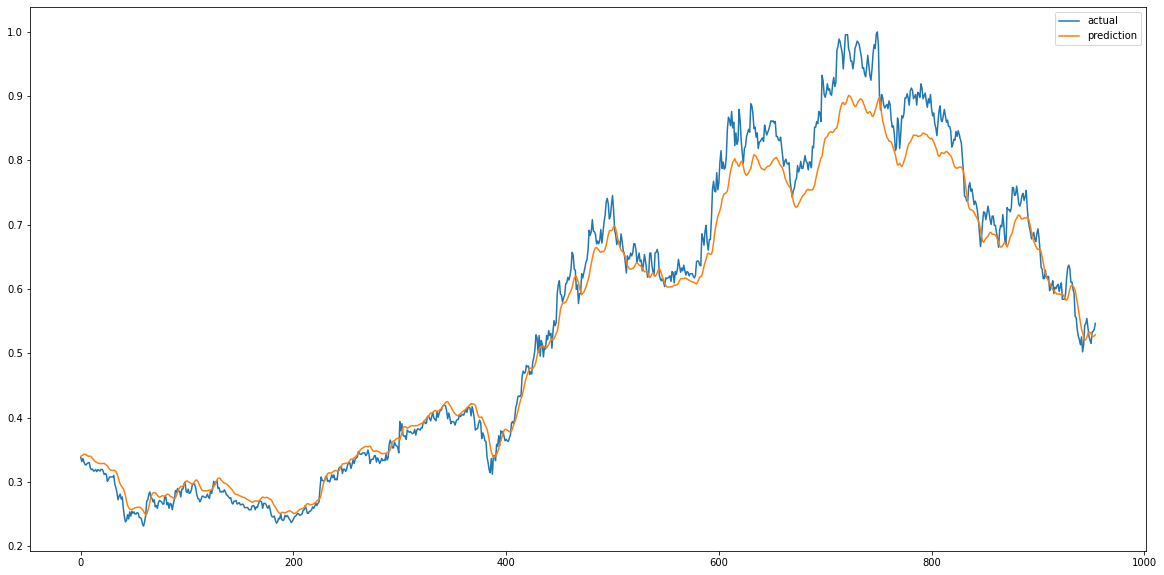

In [41]:
plt.figure(figsize=(20, 10))
plt.plot(np.asarray(y_test)[20:], label='actual')
plt.plot(pred, label='prediction')
plt.legend()
plt.show()